In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import notebook
import pytz
import datetime
import math

### 

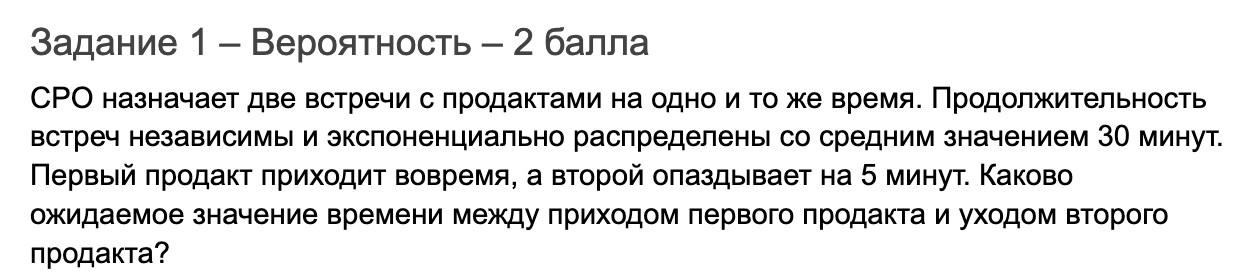

1. **Input:**

    Assume $\eta, \xi - Exp(30)$ - 1st & 2nd meetings duration (distribution constant $\lambda = 1/30$).
    
    Second meetings' start is shifted from the first one by 5 minutes


2. **What is "time between the 1st PM is in and the 2nd is out"?**

    In fact, it can be represented by the following RV:

    $$\alpha = \eta + max(\xi, 5)$$
    

3. **Find  E$\alpha$**:

    $$\mathbb{E}(\alpha) = \mathbb{E}(\eta + max(\xi, 5)) = \mathbb{E}(\eta) + \mathbb{E}(max(\xi, 5))$$
    
    $$\mathbb{E}(\eta) = 1/\lambda [ = 30]$$
    $$\mathbb{E}(max(\xi, 5)) = \int_0^5 5*\lambda*\exp(-\lambda x)*dx + \int_5^\inf x*\lambda*\exp(-\lambda x)*dx$$
    $$\mathbb{E}(max(\xi, 5)) = 5(1 - \exp(-5\lambda)) + \frac{1}{\lambda}(1+5\lambda)*\exp(-5\lambda) = 5 + \frac{1}{\lambda}\exp(-5\lambda)$$
    
    Finally:
    
    $$\mathbb{E}(\alpha) = 5 + \frac{1}{\lambda}(1+\exp(-5\lambda)) \approx 60.394$$

In [2]:
param = 1/30
val = 5 + (1/param) * (1 + math.e**(-5*param))
round(val, 3)

60.394

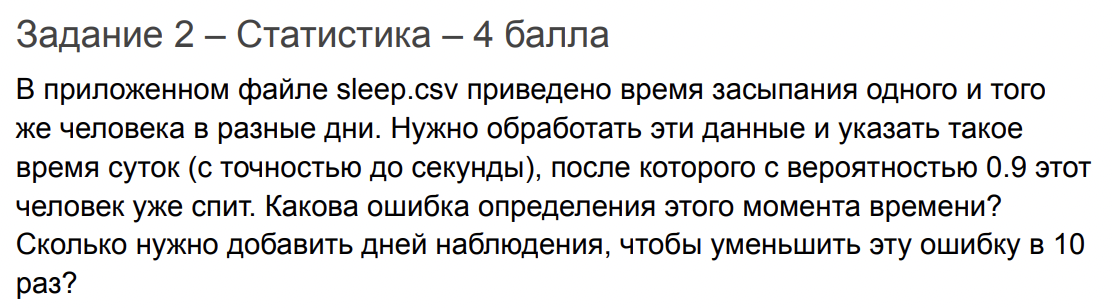

**Plan**:
1. Preprocess data and find "sleeping" points - get data sample; 
2. Bootstrap sample from step1 in order to find q90 mean and SE;
3. Find explicitly the SE function and its dependence on sample size;

#### Preprocess data

In [3]:
df = pd.read_csv('../resources/sleep_.csv', header=1, names=['datetime', 'indicator', 'time_offset'])
df.describe()

,indicator,time_offset
count,11339.000000,11339.000000
mean,0.582944,29.507893
std,0.493094,51.958506
min,0.000000,-60.000000
25%,0.000000,-15.000000
50%,1.000000,30.000000
75%,1.000000,74.500000
max,1.000000,119.000000


In [4]:
# get data for grouping
df['date'] = pd.to_datetime(df['datetime']).dt.date

# get timestamp
df['ts'] = (pd.to_datetime(df['datetime']).astype(int) - pd.to_datetime(df['date']).astype(int)) // 10**9

/var/folders/vy/1k1x8xv91279h7n8l5y2t66w0000gq/T/ipykernel_7311/4196150998.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['ts'] = (pd.to_datetime(df['datetime']).astype(int) - pd.to_datetime(df['date']).astype(int)) // 10**9


In [5]:
# find changing indicator value
df['prev_indicator'] = df.groupby(['date']).indicator.shift(1).fillna(0)

# check if there are cases with 2 "sleeping" points within 1 day
assert df[(df['prev_indicator'] != df['indicator'])].\
groupby('date').\
agg({'datetime':'nunique'}).\
datetime.unique() == 1

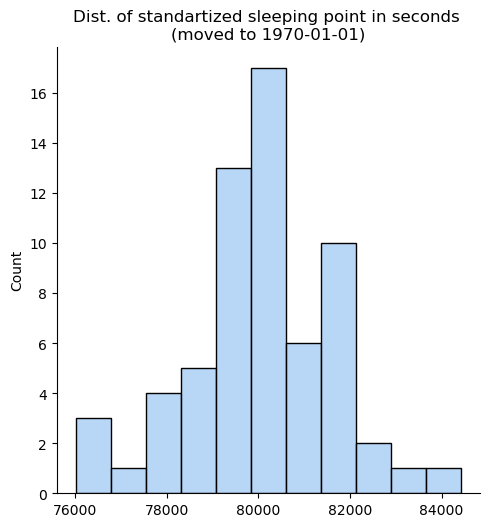

In [6]:
sns.set_palette("pastel")
sample = df[df['prev_indicator'] != df['indicator']].ts.values
plot = sns.displot(sample).set(title='Dist. of standartized sleeping point in seconds \n(moved to 1970-01-01)')

#### Bootstrap-simulations

In [7]:
B = 100_000 # b-p 
q = 0.9 # quantile of interest
alpha = 0.05 # I error for CI

bs = []

for i in notebook.tqdm(range(B)):
    bs.append(np.quantile(np.random.choice(sample, size=len(sample), replace=True), q))

Xq = round(np.mean(bs))
SE_hat = round(np.std(bs))
CI = [round(np.quantile(bs, alpha/2)), round(np.quantile(bs, 1-alpha/2))]

print(Xq, SE_hat, CI)

  0%|          | 0/100000 [00:00<?, ?it/s]

81974 185 [81708, 82320]


In [8]:
def get_time(ts):
    tz = pytz.timezone('UTC')
    return datetime.datetime.fromtimestamp(ts, tz).time()

In [9]:
print(f'After this time, the person sleeps with a 90% probability: \t{get_time(Xq)}')
print(f'SE: \t{get_time(SE_hat)}')
print(f'95% confidence interval: \t[{get_time(CI[0])}; {get_time(CI[1])}]')

After this time, the person sleeps with a 90% probability: 	22:46:14
SE: 	00:03:05
95% confidence interval: 	[22:41:48; 22:52:00]


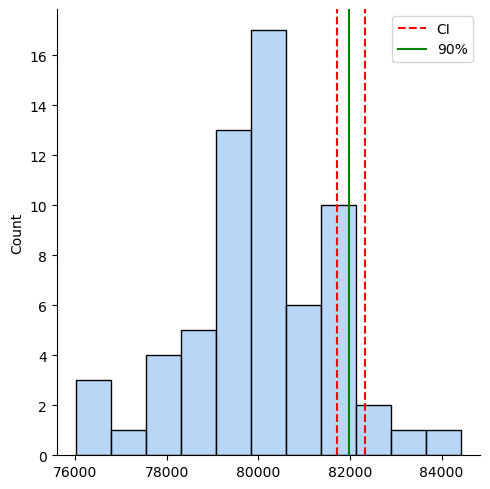

In [10]:
sns.set_palette("pastel")
plot = sns.displot(sample)
left = plt.axvline(CI[0], color='red', linestyle='--')
right = plt.axvline(CI[1], color='red', linestyle='--')
q90 = plt.axvline(Xq, color='green', linestyle='-')
plt.legend([left, q90], ['CI', '90%'])

#### SE formula

According to [this](https://www.math.mcgill.ca/~dstephens/OldCourses/556-2006/Math556-Median.pdf) paper, SE of quantile $q$ describes as:

$$ SE = \sqrt \frac {q(1-q)}{N f_x(\hat{x})} $$

So, to reduce the SE value by 10 - you need $100N$ samples: add 6237 days (wtf?!)

